In [607]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.mp.vartype import VarType
import json

In [608]:
def generate_weight_matrix(nb_nodes, p, min_weight, max_weight, debug):
    # er_graph = np.random.choice([0, 1], size=(nb_nodes, nb_nodes), p=[1 - p, p])
    # np.fill_diagonal(er_graph, 0)   
    G = nx.erdos_renyi_graph(nb_nodes, p)
    er_graph = nx.to_numpy_array(G)
    weights = np.random.randint(min_weight, max_weight, size=(nb_nodes, nb_nodes))
    W_adj = er_graph * weights
    W_adj = (W_adj + W_adj.T) // 2
    if debug:
        print(f"Weight Matrix:\n{W_adj}")
    return W_adj

In [610]:
def generate_demands(nb_demands, nb_nodes, nb_timesteps, max_eprs, debug):
    demand_sizes = np.random.randint(1, max_eprs, size=nb_demands)

    all_pairs = []
    for i in range(nb_nodes):
        for j in range(nb_nodes):
            if i != j:
                all_pairs.append((i, j))
    demand_pairs = random.choices(all_pairs, k=nb_demands)
    start_nodes, end_nodes = list(zip(*demand_pairs))

    all_intervals = []
    for i in range(nb_timesteps):
        for j in range(i + 1, nb_timesteps):
            all_intervals.append((i, j))
    demand_intervals = random.choices(all_intervals, k=nb_demands)
    start_times, end_times = list(zip(*demand_intervals))

    demand_list = list(
        zip(start_nodes, end_nodes, demand_sizes, start_times, end_times)
    )

    return demand_list

In [611]:
def create_digraph(W_adj):
    np.random.seed(42)
    nb_nodes = W_adj.shape[0]
    labels = [i for i in range(nb_nodes)]
    W_df = pd.DataFrame(W_adj, index=labels, columns=labels)
    G_digraph = nx.from_pandas_adjacency(W_df, create_using=nx.DiGraph())
    return G_digraph

In [612]:
def plot_digraph(G, filename):
    plt.figure()
    positions = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, positions)
    nx.draw_networkx_edges(G, pos=positions, width=1.0)
    edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, positions)
    # plt.savefig(filename)
    plt.show()

In [613]:
def add_variables(model, W_adj, nb_demands, nb_timesteps, nb_nodes, debug):
    variables = model.integer_var_dict(
        [
            (i, t, u, v)
            for i in range(nb_demands)
            for t in range(nb_timesteps)
            for u in range(nb_nodes)
            for v in range(nb_nodes)
            if W_adj[u][v] != 0
        ],
        name="f",
    )
    if debug:
        for var_key in variables:
            print(variables[var_key].name)
    return variables

In [614]:
def define_objective(model, W_adj, nb_demands, nb_nodes, demand_list, variables, debug):
    objective = 0
    for i in range(nb_demands):
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            for v in range(nb_nodes):
                if W_adj[demand_list[i][0]][v] != 0:
                    if debug: 
                        print(
                            (i, t, demand_list[i][0], v),
                            variables[(i, t, demand_list[i][0], v)],
                        )
                        print()
                    objective += (
                        variables[(i, t, demand_list[i][0], v)]
                        - variables[(i, t, v, demand_list[i][0])]
                    )
    model.maximize(objective)

In [615]:
def define_constraints(
    model,
    W_adj,
    nb_timesteps,
    nb_demands,
    nb_nodes,
    demand_list,
    variables,
    nw_state,
    debug,
):
    # Constraint 1
    source_outflow = []
    for i in range(nb_demands):
        sum_allocated = model.linear_expr()
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            for v in range(nb_nodes):
                if W_adj[demand_list[i][0]][v] != 0:
                    sum_allocated += variables[(i, t, demand_list[i][0], v)]
        model.add_constraint(
            sum_allocated <= demand_list[i][2],
            f"outflow_src_demand_{i}_src_{demand_list[i][0]}",
        )
        source_outflow.append(sum_allocated)
        if debug:
            print(
                model.get_constraint_by_name(
                    f"outflow_src_demand_{i}_src_{demand_list[i][0]}"
                )
            )
            print()

    # Constraint 2
    for i in range(nb_demands):
        sum_allocated = model.linear_expr()
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            for u in range(nb_nodes):
                if W_adj[u][demand_list[i][1]] != 0:
                    sum_allocated += variables[(i, t, u, demand_list[i][1])]
        model.add_constraint(
            sum_allocated == source_outflow[i],
            f"inflow_dest_demand_{i}_dst_{demand_list[i][1]}",
        )
        if debug:
            print(
                model.get_constraint_by_name(
                    f"inflow_dest_demand_{i}_dst_{demand_list[i][1]}"
                )
            )
            print()

    # Constraint 3
    for i in range(nb_demands):
        for t in range(nb_timesteps):
            for v in range(nb_nodes):
                if v not in (demand_list[i][0], demand_list[i][1]):
                    inflow_v = model.linear_expr()
                    outflow_v = model.linear_expr()
                    for u in range(nb_nodes):
                        if W_adj[u][v] != 0:
                            inflow_v += variables[(i, t, u, v)]
                            outflow_v += variables[(i, t, v, u)]
                    if debug:
                        print(f"INFLOW_I_{i}_T_{t}_V_{v} = {inflow_v}")
                        print(f"OUTFLOW_I_{i}_T_{t}_V_{v} = {outflow_v}")
                    model.add_constraint(
                        inflow_v == outflow_v, f"flow_cons_node_i_{i}_t_{t}_v_{v}"
                    )
                    if debug:
                        print(
                            model.get_constraint_by_name(
                                f"flow_cons_node_i_{i}_t_{t}_v_{v}"
                            )
                        )

    # Constraint 4
    for t in range(nb_timesteps):
        for u in range(nb_nodes):
            for v in range(nb_nodes):
                if W_adj[u][v] != 0:
                    sum_allocated = model.linear_expr()
                    for i in range(nb_demands):
                        sum_allocated += variables[(i, t, u, v)]
                    model.add_constraint(
                        sum_allocated <= nw_state[t][u][v],
                        f"edge_capacity_{u}_{v}_t_{t}",
                    )
                    if debug:
                        print(
                            model.get_constraint_by_name(f"edge_capacity_{u}_{v}_t_{t}")
                        )
                        print()

    # Constraint 5
    for i in range(nb_demands):
        sum_allocated = model.linear_expr()
        dont_allocate_time = [
            t
            for t in range(0, nb_timesteps)
            if t not in range(demand_list[i][3], demand_list[i][4])
        ]
        if debug:
            print(
                f"dont allocate time for req: {demand_list[i]} = {dont_allocate_time}"
            )
        for t in dont_allocate_time:
            for u in range(nb_nodes):
                for v in range(nb_nodes):
                    if W_adj[u][v] != 0:  # edge u->v
                        sum_allocated += variables[(i, t, u, v)]
        model.add_constraint(sum_allocated == 0, f"no_allocation_bef_after_req_{i}")
        # DEBUG PRINTING
        if debug:
            print(model.get_constraint_by_name(f"no_allocation_bef_after_req_{i}"))
            print()

    # Constraint 6
    for i in range(nb_demands):
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            sum_allocated = model.linear_expr()
            for u in range(nb_nodes):
                for v in range(nb_nodes):
                    if W_adj[u][v] != 0:  # edge from  u -> v
                        sum_allocated += variables[(i, t, u, v)]
            model.add_constraint(
                sum_allocated <= demand_list[i][2],
                f"max_allocation_demand_{i}_t_{t}",
            )
            if debug:
                print(model.get_constraint_by_name(f"max_allocation_demand_{i}_t_{t}"))
                print()

In [616]:
def generate_flow_matrix(vars, nb_demands, nb_timesteps, nb_nodes, debug):
    F = np.zeros(shape=(nb_demands, nb_timesteps, nb_nodes, nb_nodes))
    print("")
    print("")
    print("FLOWS")
    print("-------------------")
    print("[i, t, u, v] | flow")
    print("-------------------")
    for v in vars:
        if v["value"] != 0:
            id = v["name"]
            id = id.split("_")[1:]
            id = list(map(int, id))
            F[id[0], id[1], id[2], id[3]] = float(v["value"])
            print(f"{id} | {v['value']}")
    print("-------------------")
    return F

In [617]:
def compute_served(F, demand_list):
    nb_demands = len(demand_list)
    served_count = 0
    total_eprs = 0
    for i in range(nb_demands):
        eprs_served = 0
        for t in range(F.shape[1]):
            for v in range(F.shape[2]):
                eprs_served += F[i][t][demand_list[i][0]][v]
        if eprs_served == demand_list[i][2]:
            served_count += 1
            print(f"Served demand {i}")
        total_eprs += eprs_served

    print(f"Served {served_count} out of {nb_demands} demands.")
    return served_count, total_eprs

In [618]:
def lp_solve(
    nb_nodes,
    edge_probability,
    min_weight,
    max_weight,
    nb_demands,
    nb_timesteps,
    max_eprs,
    debug,
):
    # TODO: uncomment the lines below
    W_adj = generate_weight_matrix(
        nb_nodes=nb_nodes,
        p=edge_probability,
        min_weight=min_weight,
        max_weight=max_weight,
        debug=debug,
    )
    D = generate_demands(
        nb_demands=nb_demands,
        nb_nodes=nb_nodes,
        nb_timesteps=nb_timesteps,
        max_eprs=max_eprs,
        debug=debug,
    )

    network_state = [W_adj] * (nb_timesteps + 1)

    model = Model(name="routing", log_output=False)
    model.objective_sense = "max"
    model.parameters.threads.set(1)

    G_base = create_digraph(W_adj)
    plot_digraph(G_base, "graph.png")

    variables = add_variables(
        model=model,
        W_adj=W_adj,
        nb_demands=nb_demands,
        nb_timesteps=nb_timesteps,
        nb_nodes=nb_nodes,
        debug=debug,
    )
    define_objective(
        model=model,
        W_adj=W_adj,
        nb_demands=nb_demands,
        nb_nodes=nb_nodes,
        demand_list=D,
        variables=variables,
        debug=debug,
    )
    define_constraints(
        model=model,
        W_adj=W_adj,
        nb_timesteps=nb_timesteps,
        nb_demands=nb_demands,
        nb_nodes=nb_nodes,
        demand_list=D,
        variables=variables,
        nw_state=network_state,
        debug=debug,
    )

    print("DEMANDS")
    print("------------------------------------------------------------------")
    print("Di | (start_node, end_node, requested_pairs, start_time, end_time)")
    print("------------------------------------------------------------------")
    for i, demand in enumerate(D):
        print(f"D{i} | {demand}")
    print("------------------------------------------------------------------")

    solution = model.solve()
    if solution is None:
        print("ERR: Model returned None")
        return
    sol_json = solution.export_as_json_string()

    print("----------Solution Details: -----------")
    vars = json.loads(sol_json)["CPLEXSolution"]["variables"]
    F = generate_flow_matrix(
        vars,
        nb_demands=nb_demands,
        nb_timesteps=nb_timesteps,
        nb_nodes=nb_nodes,
        debug=debug,
    )
    served_count = compute_served(F, D)
    return served_count

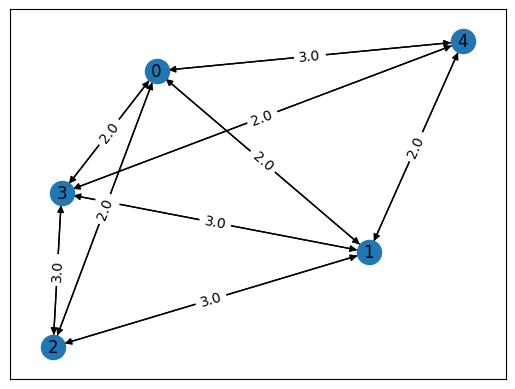

DEMANDS
------------------------------------------------------------------
Di | (start_node, end_node, requested_pairs, start_time, end_time)
------------------------------------------------------------------
D0 | (0, 3, 3, 0, 1)
D1 | (2, 3, 1, 1, 2)
D2 | (0, 3, 1, 0, 1)
------------------------------------------------------------------
----------Solution Details: -----------


FLOWS
-------------------
[i, t, u, v] | flow
-------------------
[0, 0, 0, 1] | 1.0
[0, 0, 0, 3] | 1.0
[0, 0, 1, 3] | 1.0
[1, 1, 2, 3] | 1.0
[2, 0, 0, 3] | 1.0
-------------------
Served demand 1
Served demand 2
Served 2 out of 3 demands.


(2, 4.0)

In [619]:
lp_solve(
    nb_nodes=5,
    edge_probability=0.5,
    min_weight=1,
    max_weight=5,
    nb_demands=3,
    nb_timesteps=3,
    max_eprs=5,
    debug=False,
)

Note: The solver will sacrifice completely serving a demand if partially serving it means it can serve more EPR pairs overall